## **Libraries**

In [ ]:
# Drive
from google.colab import drive

import pandas as pd
import numpy as np
import chess.pgn

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
tips = sns.load_dataset("tips")
sns.set(style='whitegrid', palette="deep", font_scale=1.1)

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# Feature Selection
from sklearn.ensemble import ExtraTreesClassifier

# Split DF into Test and Train
from sklearn.model_selection import train_test_split

# Modelling - Classification
from sklearn.linear_model import LogisticRegression
import lightgbm
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Modelling - Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# DNN
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

# Metrics
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

# For ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Label Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# Normalization - Standard Scalar
from sklearn.preprocessing import StandardScaler

#To Save Models
import pickle

## **Data**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/Shared drives/DSF_Project/dataset/Final Dataset'

/content/drive/Shared drives/DSF_Project/dataset/Final Dataset


In [ ]:
df = pd.read_csv('final_data_100000.csv')

## **Data Processing**

In [ ]:
temp_df = df.copy()

In [ ]:
temp_df.shape

### **Drop NaN values**

In [ ]:
# Count of NaN values in each row
temp_df.isna().sum()

In [ ]:
# Drop rows with NaN values
temp_df.dropna(inplace=True)

In [ ]:
temp_df.shape

In [ ]:
# Print all columns
for col in temp_df.columns: 
    print(col)

### **Drop Columns** 

In [ ]:
# Drop unnecessary columns
temp_df.drop(['Site','Date','Round','White','Black','UTCDate','UTCTime'], axis = 1, inplace=True) 

In [ ]:
# Drop columns already used to generate more features
temp_df.drop(['moves','clocks','sans'], axis = 1, inplace=True) 

### **Modify column values**

In [ ]:
# Result
for i, row in temp_df.iterrows():
  
  value = temp_df['Result'][i]
  new_value = 2     # Draw (Default)

  if value=="1-0":
    new_value = "1" # White wins
  elif value=="0-1":
    new_value = "0" # Black wins

  # Set value
  temp_df.set_value(i,'Result', new_value)

# Change Datatype to float
temp_df.Result = temp_df.Result.astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [ ]:
# Time Control

# Add 3 columns
temp_df['TimeControl_FixedTime'] = temp_df['ID']  
temp_df['TimeControl_Increment'] = temp_df['ID']  
temp_df['TimeControl_TotalTime'] = temp_df['ID']  

# Calculate and add values to TimeControl column
for i, row in temp_df.iterrows():
  split = str(temp_df['TimeControl'][i]).split('+')
  left = float(split[0])/60
  right = float(split[1])*40/60
  total = left+right
  temp_df.set_value(i,'TimeControl_TotalTime', total)
  temp_df.set_value(i,'TimeControl_TotalTime', total)
  temp_df.set_value(i,'TimeControl_TotalTime', total)

# Drop TimeControl column
temp_df.drop(['TimeControl'], axis = 1, inplace=True) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


In [ ]:
# Termination - Drop rows with Termination = 'Abandoned'
temp_df = temp_df[temp_df.Termination != 'Abandoned']

In [ ]:
# Elo Classes

# White
temp_df['WhiteEloClass'] = temp_df['Event'].copy()
for i, row in temp_df.iterrows():
  value = temp_df['WhiteElo'][i]
  new_value = "Mid"

  if value<1500:
    new_value = "Low"
  elif value>2000:
    new_value = "High"

  temp_df.set_value(i,'WhiteEloClass', new_value)


# Black
temp_df['BlackEloClass'] = temp_df['Event'].copy()
for i, row in temp_df.iterrows():
  value = temp_df['BlackElo'][i]
  new_value = "Mid"
  
  if value<1500:
    new_value = "Low"
  elif value>2000:
    new_value = "High"  

  temp_df.set_value(i,'BlackEloClass', new_value)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [ ]:
# Board End State

# Create columns
for i in range(64):
  temp_df['board_position_'+str(i)] = 'NaN'

# Split into 64 columns
def set_board_features(row):
  board = chess.Board(fen=row['end_board_fen'])
  for key, value in board.piece_map().items():
    row['board_position_'+str(key)] = value
  return row

# Apply changes 
temp_df = temp_df.apply(set_board_features, axis=1)

# Delete 'end_board_fen'
temp_df.drop(['end_board_fen'], axis = 1, inplace=True)

In [ ]:
# Add 12 rows containing all 12 possible board pieces (To ensure Label Encoding is done properly)
temp_row = temp_df.iloc[0].copy()
type_of_pieces = ['r','n','b','q','k','p','P','K','Q','B','N','R']

for piece in type_of_pieces:
  for i in range(64):
    temp_row['board_position_' + str(i)] = piece
  temp_row['ID'] = 9999999
  temp_df = temp_df.append(temp_row, ignore_index=True)

In [ ]:
temp_df.shape

(98808, 113)

In [ ]:
# Save CSV
temp_df.to_csv("temp_dataset_preprocessed_before_encoding.csv",index=False)

In [ ]:
temp_df

,ID,Event,Result,BlackElo,BlackRatingDiff,ECO,Opening,Termination,WhiteElo,WhiteRatingDiff,total_moves,white_eval,black_eval,white_moves,black_moves,early_game_eval,middle_game_eval,end_game_eval,black_pawn_promote,black_king_castling,black_queen_castling,black_capture,black_checks,white_pawn_promote,white_king_castling,white_queen_castling,white_capture,white_checks,black_GOOD_MOVE,black_MISTAKE,black_BRILLIANT_MOVE,black_BLUNDER,black_SPECULATIVE_MOVE,black_DUBIOUS_MOVE,white_GOOD_MOVE,white_MISTAKE,white_BRILLIANT_MOVE,white_BLUNDER,white_SPECULATIVE_MOVE,white_DUBIOUS_MOVE,...,board_position_24,board_position_25,board_position_26,board_position_27,board_position_28,board_position_29,board_position_30,board_position_31,board_position_32,board_position_33,board_position_34,board_position_35,board_position_36,board_position_37,board_position_38,board_position_39,board_position_40,board_position_41,board_position_42,board_position_43,board_position_44,board_position_45,board_position_46,board_position_47,board_position_48,board_position_49,board_position_50,board_position_51,board_position_52,board_position_53,board_position_54,board_position_55,board_position_56,board_position_57,board_position_58,board_position_59,board_position_60,board_position_61,board_position_62,board_position_63
0,15000,Bullet,0,2066,12.0,A28,"English Opening: King's English Variation, Fou...",Normal,2061,-13.0,80,-9.700000,-0.242500,40,40,50.950000,76.350000,156.400000,0,False,True,11,5,0,False,False,7,3,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,p,n,NaN,NaN,NaN,NaN,NaN,P,NaN,NaN,NaN,NaN,NaN,p,NaN,p,NaN,n,NaN,NaN,NaN,NaN,NaN,NaN,k,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b
1,15001,Blitz,0,1395,7.0,A00,Hungarian Opening: Sicilian Invitation,Time forfeit,1274,-7.0,56,-12.071429,-0.431122,28,28,62.071429,59.428571,98.571429,0,True,False,8,4,0,False,False,8,1,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p,NaN,n,b,NaN,NaN,NaN,R,NaN,p,NaN,NaN,q,p,NaN,N,NaN,k,r,NaN,NaN,NaN,NaN,NaN
2,15002,Bullet,0,2002,1.0,D02,Queen's Pawn Game: Zukertort Variation,Time forfeit,1433,-2.0,130,1279.553846,19.685444,65,65,26.968750,82.600000,723.575758,0,False,False,14,9,0,False,False,13,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15003,Blitz,0,1398,12.0,C23,Bishop's Opening,Normal,1434,-12.0,60,-277.000000,-9.233333,30,30,45.400000,40.533333,-22.666667,0,True,False,12,0,0,True,False,10,7,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p,NaN,p,NaN,NaN,NaN,p,p,NaN,NaN,NaN,NaN,NaN,NaN,k,NaN
4,15004,Bullet,0,1650,13.0,B80,Sicilian Defense: Scheveningen Variation,Time forfeit,1721,-13.0,82,-116.365854,-2.838192,41,41,39.350000,78.926829,207.904762,0,True,False,11,2,0,True,False,11,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,r,k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98803,9999999,Bullet,0,2066,12.0,A28,"English Opening: King's English Variation, Fou...",Normal,2061,-13.0,80,-9.700000,-0.242500,40,40,50.950000,76.350000,156.400000,0,False,True,11,5,0,False,False,7,3,0,0,0,0,0,0,0,0,0,0,0,0,...,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K,K
98804,9999999,Bullet,0,2066,12.0,A28,"English Opening: King's English Variation, Fou...",Normal,2061,-13.0,80,-9.700000,-0.242500,40,40,50.950000,76.350000,156.400000,0,False,True,11,5,0,False,False,7,3,0,0,0,0,0,0,0,0,0,0,0,0,...,Q,Q,Q,Q,Q,Q,Q,Q

### **Label Encoding**

In [ ]:
# Categorical boolean mask
cat_ft1 = temp_df.dtypes==object

# filter categorical columns using mask and turn it into a list
cat_cols1 = temp_df.columns[cat_ft1].tolist()

# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
temp_df[cat_cols1] = temp_df[cat_cols1].apply(lambda col: le.fit_transform(col.astype(str)))

### **Drop extra rows of board positions**

In [ ]:
temp_df = temp_df[temp_df.ID != 9999999]

### **Separate White and Black Datasets**

In [ ]:
# Make a copy
white_df = temp_df.copy()
black_df = temp_df.copy()

# Drop black columns
white_df.drop(white_df.columns[[3,4,12,14,18,19,20,21,22,28,29,30,31,32,33,41,43,48]], axis = 1, inplace=True) 
# Drop white columns
black_df.drop(black_df.columns[[8,9,11,13,23,24,25,26,27,34,35,36,37,38,39,40,42,47]], axis = 1, inplace=True) 

In [ ]:
# Save CSV
white_df.to_csv("temp_white_dataset_preprocessed_after_encoding.csv",index=False)
black_df.to_csv("temp_black_dataset_preprocessed_after_encoding.csv",index=False)

## **Modelling**

In [ ]:
# Save Models Location
loc = '/content/drive/Shared drives/DSF_Project/Models/100000_AllFeat_LE/'

### **1. ELO Rating Prediction - Classification**

In [ ]:
# Update Models location
loc_model1 = loc+'ELOClass/'

#### **Data Processing - White**

In [ ]:
# Make a copy of DF
df_w1 = white_df.copy()
df_w1.drop(['ID','WhiteElo','WhiteEloClass'], axis=1, inplace=True)

In [ ]:
# Target data
target_df_w1 = white_df['WhiteEloClass'].copy()

# Split Data
#train1, validate1, test1 = np.split(df1.sample(frac=1), [int(.6*len(df1)), int(.8*len(df1))])
X_train_w1, X_test_w1, y_train_w1, y_test_w1 = train_test_split(df_w1, target_df_w1, test_size=0.2)


#### **Data Processing - Black**

In [ ]:
# Make a copy of DF
df_b1 = black_df.copy()
df_b1.drop(['ID','BlackElo','BlackEloClass'], axis=1, inplace=True)

In [ ]:
# Target data
target_df_b1 = black_df['BlackEloClass'].copy()

# Split Data
#train1, validate1, test1 = np.split(df1.sample(frac=1), [int(.6*len(df1)), int(.8*len(df1))])
X_train_b1, X_test_b1, y_train_b1, y_test_b1 = train_test_split(df_b1, target_df_b1, test_size=0.2)

#### **Correlation**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


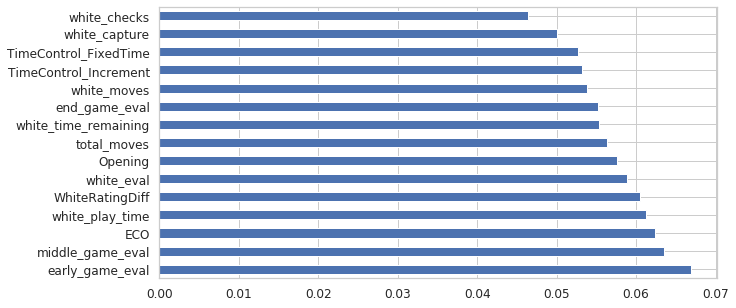

In [ ]:
# Select Best Features based on best prediction for target = WhiteEloClass

# Data
X = df_w1.iloc[:, :28].copy()
Y = target_df_w1

# Build Model
model = ExtraTreesClassifier()
model.fit(X,Y)

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
fig = plt.figure(figsize=(10,5))
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

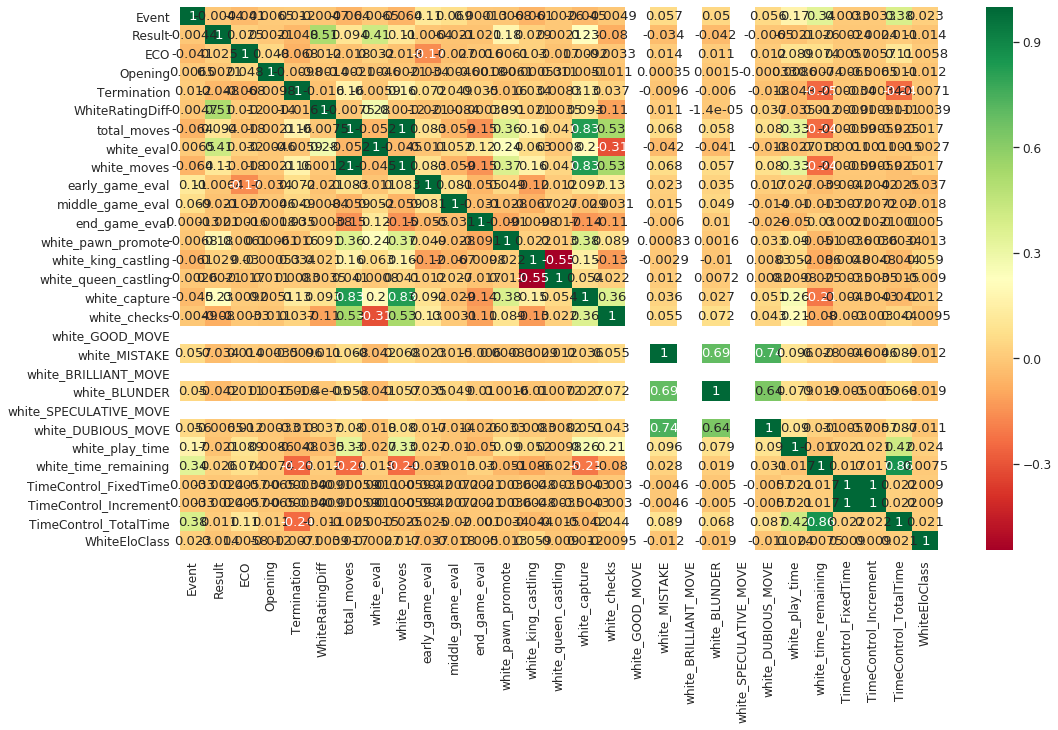

In [ ]:
# Get Correlation

# Select 15 Features
cols = list(feat_importances.index)

# Add SWhiteElo to Best Features to compare correlation
cols.append('WhiteEloClass')
corr_df_w1 = white_df[cols]

# Find Correlation
corrmat = corr_df_w1.corr()
top_corr_features = corrmat.index

# Plot Heat Map
plt.figure(figsize=(17,10))
g=sns.heatmap(temp_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


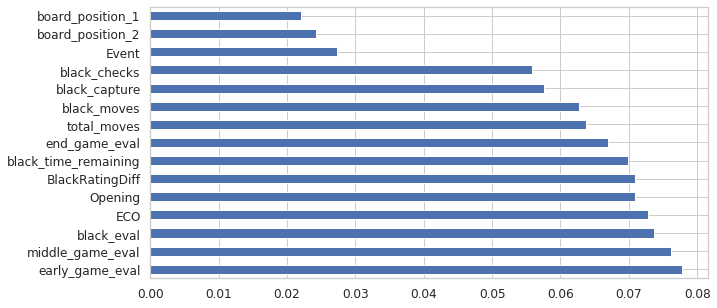

In [ ]:
# Select Best Features based on best prediction for target = BlackEloClass

# Data
X = (df_b1.iloc[:, :28]).copy()
Y = target_df_b1

# Build Model
model = ExtraTreesClassifier()
model.fit(X,Y)

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
fig = plt.figure(figsize=(10,5))
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

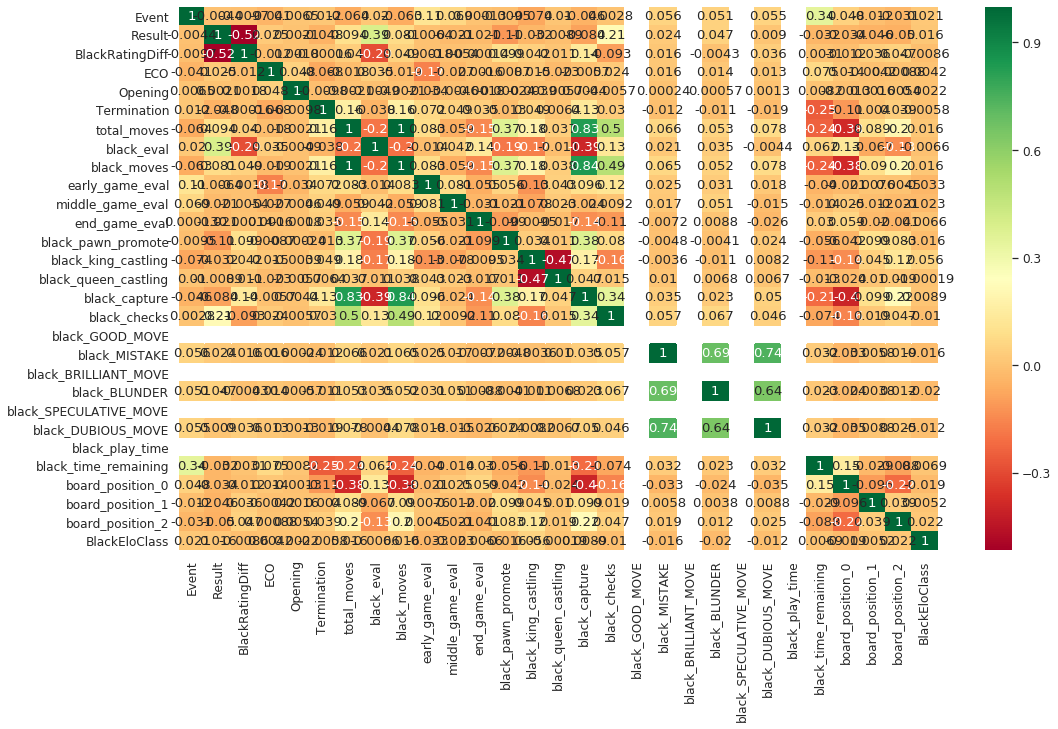

In [ ]:
# Get Correlation

# Select 15 Features
cols = list(feat_importances.index)

# Add BlackEloClass to Best Features to compare correlation
cols.append('BlackEloClass')
corr_df_b1 = black_df[cols]

# Find Correlation
corrmat = corr_df_b1.corr()
top_corr_features = corrmat.index

# Plot Heat Map
plt.figure(figsize=(17,10))
g=sns.heatmap(temp_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### **Logistic Regression**

In [ ]:
# Train Model
logreg_w1 = LogisticRegression().fit(X_train_w1, y_train_w1)
logreg_b1 = LogisticRegression().fit(X_train_b1, y_train_b1)

# Save Model
pickle.dump(logreg_w1, open(loc_model1+'logreg_w1.sav', 'wb'))
pickle.dump(logreg_b1, open(loc_model1+'logreg_b1.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
# Use Saved Model
logreg_w1m = pickle.load(open(loc_model1+'logreg_w1.sav', 'rb'))
logreg_b1m = pickle.load(open(loc_model1+'logreg_b1.sav', 'rb'))

In [ ]:
# Prediction
prediction_logreg_w1 = logreg_w1.predict(X_test_w1)
prediction_logreg_b1 = logreg_b1.predict(X_test_b1)

In [ ]:
# # Plot Prediction V/s Actual
# fig = plt.figure(figsize=(10,5))
# sns.lineplot(data=y_test_w1, x="ID", y="WhiteEloClass").set(xlabel='Year Built', ylabel='Sale Price', title='Sale Prices of BldgTypes over the Years');
# sns.lineplot(data=predicted_w1, x="ID", y="WhiteEloClass").set(xlabel='Year Built', ylabel='Sale Price', title='Sale Prices of BldgTypes over the Years');

In [ ]:
# Accuracy
print ("Accuracy - White: %.2f%%" % (accuracy_score(y_test_w1, prediction_logreg_w1)*100))
print ("Accuracy - Black: %.2f%%" % (accuracy_score(y_test_b1, prediction_logreg_b1)*100))

Accuracy - White: 61.21%
Accuracy - Black: 61.09%


#### **Light GBM**

In [ ]:
# Train Model

parameters = {
    'application': 'multiclass',
    'objective': 'multiclass',
    'num_class':3,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

# White
categorical_features_w1 = [c for c, col in enumerate(X_train_w1.columns) if 'cat' in col]
train_data_w1 = lightgbm.Dataset(X_train_w1, label=y_train_w1, categorical_feature=categorical_features_w1)
test_data_w1 = lightgbm.Dataset(X_test_w1, label=y_test_w1)

# Black
categorical_features_b1 = [c for c, col in enumerate(X_train_b1.columns) if 'cat' in col]
train_data_b1 = lightgbm.Dataset(X_train_b1, label=y_train_b1, categorical_feature=categorical_features_b1)
test_data_b1 = lightgbm.Dataset(X_test_b1, label=y_test_b1)

In [ ]:
# Train

# White
lgbm_w1 = lightgbm.train(parameters,
                       train_data_w1,
                       valid_sets=test_data_w1,
                       num_boost_round=5000,
                       early_stopping_rounds=100)


# Save Model
pickle.dump(lgbm_w1, open(loc_model1+'lgbm_w1.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_logloss: 0.903523
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 0.897944
[3]	valid_0's multi_logloss: 0.892915
[4]	valid_0's multi_logloss: 0.887738
[5]	valid_0's multi_logloss: 0.883328
[6]	valid_0's multi_logloss: 0.879712
[7]	valid_0's multi_logloss: 0.875411
[8]	valid_0's multi_logloss: 0.871787
[9]	valid_0's multi_logloss: 0.867947
[10]	valid_0's multi_logloss: 0.864844
[11]	valid_0's multi_logloss: 0.861052
[12]	valid_0's multi_logloss: 0.857599
[13]	valid_0's multi_logloss: 0.8544
[14]	valid_0's multi_logloss: 0.851587
[15]	valid_0's multi_logloss: 0.848546
[16]	valid_0's multi_logloss: 0.845482
[17]	valid_0's multi_logloss: 0.843007
[18]	valid_0's multi_logloss: 0.840222
[19]	valid_0's multi_logloss: 0.837828
[20]	valid_0's multi_logloss: 0.83516
[21]	valid_0's multi_logloss: 0.832879
[22]	valid_0's multi_logloss: 0.830583
[23]	valid_0's multi_logloss: 0.828338
[24]	valid_0's multi_logloss: 0.82612
[25]	valid_0's

In [ ]:
# Black
lgbm_b1 = lightgbm.train(parameters,
                       train_data_b1,
                       valid_sets=test_data_b1,
                       num_boost_round=5000,
                       early_stopping_rounds=100)


# Save Model
pickle.dump(lgbm_b1, open(loc_model1+'lgbm_b1.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_logloss: 0.913601
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 0.909329
[3]	valid_0's multi_logloss: 0.905703
[4]	valid_0's multi_logloss: 0.901713
[5]	valid_0's multi_logloss: 0.897108
[6]	valid_0's multi_logloss: 0.893387
[7]	valid_0's multi_logloss: 0.889602
[8]	valid_0's multi_logloss: 0.885885
[9]	valid_0's multi_logloss: 0.882819
[10]	valid_0's multi_logloss: 0.87946
[11]	valid_0's multi_logloss: 0.876237
[12]	valid_0's multi_logloss: 0.873255
[13]	valid_0's multi_logloss: 0.870919
[14]	valid_0's multi_logloss: 0.868352
[15]	valid_0's multi_logloss: 0.865961
[16]	valid_0's multi_logloss: 0.863801
[17]	valid_0's multi_logloss: 0.861226
[18]	valid_0's multi_logloss: 0.858879
[19]	valid_0's multi_logloss: 0.85661
[20]	valid_0's multi_logloss: 0.854336
[21]	valid_0's multi_logloss: 0.851926
[22]	valid_0's multi_logloss: 0.849765
[23]	valid_0's multi_logloss: 0.847968
[24]	valid_0's multi_logloss: 0.846282
[25]	valid_0

In [ ]:
# Use Saved Model
lgbm_w1m = pickle.load(open(loc_model1+'lgbm_w1.sav', 'rb'))
lgbm_b1m = pickle.load(open(loc_model1+'lgbm_b1.sav', 'rb'))

In [ ]:
# Prediction
prediction_lgbm_w1 = lgbm_w1.predict(X_test_w1)
prediction_lgbm_b1 = lgbm_b1.predict(X_test_b1)

In [ ]:
########################### NOT WORKING ####################################
# print ("Score - White:", lgbm_w1.score(X_test_w1, y_test_w1))
# print ("Score - Black:", lgbm_b1.score(X_test_b1, y_test_b1))

# auc = roc_auc_score(y_test_w1, prediction_lgbm_w1)
# print('AUC: %.4f' % auc)

#### **XGB**

In [ ]:
# Train Model
xgb_w1 = XGBClassifier().fit(X_train_w1, y_train_w1)
xgb_b1 = XGBClassifier().fit(X_train_b1, y_train_b1)


# Save Model
pickle.dump(xgb_w1, open(loc_model1+'xgb_w1.sav', 'wb'))
pickle.dump(xgb_b1, open(loc_model1+'xgb_b1.sav', 'wb'))

In [ ]:
# Use Saved Model
xgb_w1m = pickle.load(open(loc_model1+'xgb_w1.sav', 'rb'))
xgb_b1m = pickle.load(open(loc_model1+'xgb_b1.sav', 'rb'))

In [ ]:
# Prediction
prediction_xgb_w1 = xgb_w1.predict(X_test_w1)
prediction_xgb_b1 = xgb_b1.predict(X_test_b1)

In [ ]:
# Accuracy
print ("Accuracy - White: %.2f%%" % (accuracy_score(y_test_w1, prediction_xgb_w1)*100))
print ("Accuracy - Black: %.2f%%" % (accuracy_score(y_test_b1, prediction_xgb_b1)*100))

Accuracy - White: 65.29%
Accuracy - Black: 63.65%


#### **Decision Tree**

In [ ]:
# Train Model
dt_w1 = DecisionTreeClassifier().fit(X_train_w1, y_train_w1)
dt_b1 = DecisionTreeClassifier().fit(X_train_b1, y_train_b1)

# Save Model
pickle.dump(dt_w1, open(loc_model1+'dt_w1.sav', 'wb'))
pickle.dump(dt_b1, open(loc_model1+'dt_b1.sav', 'wb'))

In [ ]:
# Use Saved Model
dt_w1m = pickle.load(open(loc_model1+'dt_w1.sav', 'rb'))
dt_b1m = pickle.load(open(loc_model1+'dt_b1.sav', 'rb'))

In [ ]:
# Prediction
prediction_dt_w1 = dt_w1.predict(X_test_w1)
prediction_dt_b1 = dt_b1.predict(X_test_b1)

In [ ]:
# Accuracy
print ("Accuracy - White: %.2f%%" % (accuracy_score(y_test_w1, prediction_dt_w1)*100))
print ("Accuracy - Black: %.2f%%" % (accuracy_score(y_test_b1, prediction_dt_b1)*100))

Accuracy - White: 52.28%
Accuracy - Black: 51.08%


#### **Random Forest**

In [ ]:
# Train Model
rf_w1 = RandomForestClassifier().fit(X_train_w1, y_train_w1)
rf_b1 = RandomForestClassifier().fit(X_train_b1, y_train_b1)

# Save Model
pickle.dump(rf_w1, open(loc_model1+'rf_w1.sav', 'wb'))
pickle.dump(rf_b1, open(loc_model1+'rf_b1.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
# Use Saved Model
rf_w1m = pickle.load(open(loc_model1+'rf_w1.sav', 'rb'))
rf_b1m = pickle.load(open(loc_model1+'rf_b1.sav', 'rb'))

In [ ]:
# Prediction
prediction_rf_w1 = rf_w1.predict(X_test_w1)
prediction_rf_b1 = rf_b1.predict(X_test_b1)

In [ ]:
# Accuracy
print ("Accuracy - White: %.2f%%" % (accuracy_score(y_test_w1, prediction_rf_w1)*100))
print ("Accuracy - Black: %.2f%%" % (accuracy_score(y_test_b1, prediction_rf_b1)*100))

Accuracy - White: 60.63%
Accuracy - Black: 59.01%


#### **KNN**

In [ ]:
# Train Model
knn_w1 = KNeighborsClassifier().fit(X_train_w1, y_train_w1)
knn_b1 = KNeighborsClassifier().fit(X_train_b1, y_train_b1)

# Save Model
pickle.dump(knn_w1, open(loc_model1+'knn_w1.sav', 'wb'))
pickle.dump(knn_b1, open(loc_model1+'knn_b1.sav', 'wb'))

In [ ]:
# Use Saved Model
knn_w1m = pickle.load(open(loc_model1+'knn_w1.sav', 'rb'))
knn_b1m = pickle.load(open(loc_model1+'knn_b1.sav', 'rb'))

In [ ]:
# Prediction
prediction_knn_w1 = knn_w1.predict(X_test_w1)
prediction_knn_b1 = knn_b1.predict(X_test_b1)

In [ ]:
# Accuracy
print ("Accuracy - White: %.2f%%" % (accuracy_score(y_test_w1, prediction_knn_w1)*100))
print ("Accuracy - Black: %.2f%%" % (accuracy_score(y_test_b1, prediction_knn_b1)*100))

Accuracy - White: 49.48%
Accuracy - Black: 54.67%


#### **SVM**

In [ ]:
# Train Model
# svm_w1 = SVC(kernel='linear').fit(X_train_w1, y_train_w1)
# svm_b1 = SVC(kernel='linear').fit(X_train_b1, y_train_b1)

# Save Model
# pickle.dump(svm_w1, open(loc_model1+'svm_w1.sav', 'wb'))
# pickle.dump(svm_b1, open(loc_model1+'svm_b1.sav', 'wb'))

In [ ]:
# Use Saved Model
# svm_w1m = pickle.load(open(loc_model1+'svm_w1.sav', 'rb'))
# svm_b1m = pickle.load(open(loc_model1+'svm_b1.sav', 'rb'))

In [ ]:
# Prediction
# prediction_svm_w1 = svm_w1.predict(X_test_w1)
# prediction_svm_b1 = svm_b1.predict(X_test_b1)

In [ ]:
# Accuracy
# print ("Accuracy - White: %.2f%%" % (accuracy_score(y_test_w1, prediction_svm_w1)*100))
# print ("Accuracy - Black: %.2f%%" % (accuracy_score(y_test_b1, prediction_svm_b1)*100))

#### **DNN Classifier**

In [ ]:
# Get estimator

feature_cols_w1 = [tf.feature_column.numeric_column(col) for col in df_w2.columns]
dnn_w1 = tf.estimator.DNNClassifier(feature_columns=feature_cols_w1, hidden_units=[50, 50], model_dir=loc_model1)

feature_cols_b1 = [tf.feature_column.numeric_column(col) for col in df_b2.columns]
dnn_b1 = tf.estimator.DNNClassifier(feature_columns=feature_cols_b1, hidden_units=[50, 50], model_dir=loc_model1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/drive/Shared drives/DSF_Project/Models/100000_AllFeat_LE/ELOClass/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa09feb0278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 

In [ ]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [ ]:
# Training

# WhiteEloClass
for i in range(50):
    dnn_w1.train(input_fn = wx_input_fn(X_train_w1, y=y_train_w1), steps=400)

# BlackEloClass
for i in range(50):
    dnn_b1.train(input_fn = wx_input_fn(X_train_b1, y=y_train_b1), steps=400)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /content/drive/Shared drives/DSF_Project/Models/100000_AllFeat_LE/ELOClass/model.ckpt.


InvalidArgumentError: ignored

In [ ]:
# Predictions

pred_w1 = dnn_w1.predict(input_fn = wx_input_fn(X_test_w1, num_epochs=1, shuffle=False))
prediction_dnn_w1 = np.array([p['predictions'][0] for p in pred_w1])

pred_b1 = dnn_b1.predict(input_fn = wx_input_fn(X_test_b1, num_epochs=1, shuffle=False))
prediction_dnn_b1 = np.array([p['predictions'][0] for p in pred_b1])

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w1, prediction_dnn_w1)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b1, prediction_dnn_b1)))

### **2. ELO Rating Prediction - Regression**

In [ ]:
# Update Models location
loc_model2 = loc+'ELOReg/'

#### **Data Processing - White**

In [ ]:
# Make a copy of DF
df_w2 = white_df.copy()
df_w2.drop(['ID','WhiteElo','WhiteEloClass'], axis=1, inplace=True)

In [ ]:
# Target data
target_df_w2 = white_df['WhiteElo'].copy()

# Split Data
X_train_w2, X_test_w2, y_train_w2, y_test_w2 = train_test_split(df_w2, target_df_w2, test_size=0.2)

In [ ]:
target_df_w2.shape

(98796,)

#### **Data Processing - Black**

In [ ]:
# Make a copy of DF
df_b2 = black_df.copy()
df_b2.drop(['ID','BlackElo','BlackEloClass'], axis=1, inplace=True)

In [ ]:
# Target data
target_df_b2 = black_df['BlackElo'].copy()

# Split Data
X_train_b2, X_test_b2, y_train_b2, y_test_b2 = train_test_split(df_b2, target_df_b2, test_size=0.2)

#### **Linear Regression**

In [ ]:
# Train Model
linreg_w2 = LinearRegression().fit(X_train_w2, y_train_w2)
linreg_b2 = LinearRegression().fit(X_train_b2, y_train_b2)

# Save Model
pickle.dump(linreg_w2, open(loc_model2+'linreg_w2.sav', 'wb'))
pickle.dump(linreg_b2, open(loc_model2+'linreg_b2.sav', 'wb'))

In [ ]:
# Use Saved Model
linreg_w2m = pickle.load(open(loc_model2+'linreg_w2.sav', 'rb'))
linreg_b2m = pickle.load(open(loc_model2+'linreg_b2.sav', 'rb'))

In [ ]:
# Prediction
prediction_linreg_w2 = linreg_w2.predict(X_test_w2)
prediction_linreg_b2 = linreg_b2.predict(X_test_b2)

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_linreg_w2)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_linreg_b2)))

RMSE - White: 257.90
RMSE - Black: 255.97


#### **Lasso Regression**

In [ ]:
# Train Model
lasso_w2 = Lasso().fit(X_train_w2, y_train_w2)
lasso_b2 = Lasso().fit(X_train_b2, y_train_b2)

# Save Model
pickle.dump(lasso_w2, open(loc_model2+'lasso_w2.sav', 'wb'))
pickle.dump(lasso_b2, open(loc_model2+'lasso_b2.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1067871782.1030378, tolerance: 637726.6803554062
  positive)


In [ ]:
# Use Saved Model
lasso_w2m = pickle.load(open(loc_model2+'lasso_w2.sav', 'rb'))
lasso_b2m = pickle.load(open(loc_model2+'lasso_b2.sav', 'rb'))

In [ ]:
# Prediction
prediction_lasso_w2 = lasso_w2.predict(X_test_w2)
prediction_lasso_b2 = lasso_b2.predict(X_test_b2)

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_lasso_w2)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_lasso_b2)))

RMSE - White: 258.36
RMSE - Black: 256.15


#### **Ridge Regression**

In [ ]:
# Train Model
ridge_w2 = Ridge().fit(X_train_w2, y_train_w2)
ridge_b2 = Ridge().fit(X_train_b2, y_train_b2)

# Save Model
pickle.dump(ridge_w2, open(loc_model2+'ridge_w2.sav', 'wb'))
pickle.dump(ridge_b2, open(loc_model2+'ridge_b2.sav', 'wb'))

In [ ]:
# Use Saved Model
ridge_w2m = pickle.load(open(loc_model2+'ridge_w2.sav', 'rb'))
ridge_b2m = pickle.load(open(loc_model2+'ridge_b2.sav', 'rb'))

In [ ]:
# Prediction
prediction_ridge_w2 = ridge_w2.predict(X_test_w2)
prediction_ridge_b2 = ridge_b2.predict(X_test_b2)

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_ridge_w2)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_ridge_b2)))

RMSE - White: 257.90
RMSE - Black: 255.97


#### **Light GBM**

In [ ]:
# Train Model
lgbm_w2 = (LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.05)).fit(X_train_w2, y_train_w2)
lgbm_b2 = (LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.05)).fit(X_train_b2, y_train_b2)

# Save Model
pickle.dump(lgbm_w2, open(loc_model2+'lgbm_w2.sav', 'wb'))
pickle.dump(lgbm_b2, open(loc_model2+'lgbm_b2.sav', 'wb'))

In [ ]:
# Use Saved Model
lgbm_w2m = pickle.load(open(loc_model2+'lgbm_w2.sav', 'rb'))
lgbm_b2m = pickle.load(open(loc_model2+'lgbm_b2.sav', 'rb'))

In [ ]:
# Prediction
prediction_lgbm_w2 = lgbm_w2.predict(X_test_w2)
prediction_lgbm_b2 = lgbm_b2.predict(X_test_b2)

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_lgbm_w2)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_lgbm_b2)))

RMSE - White: 211.89
RMSE - Black: 212.16


#### **XGB**

In [ ]:
# Train Model 
xgb_w2 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10).fit(X_train_w2, y_train_w2)
xgb_b2 = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10).fit(X_train_b2, y_train_b2)

# Save Model
pickle.dump(xgb_w2, open(loc_model2+'xgb_w2.sav', 'wb'))
pickle.dump(xgb_b2, open(loc_model2+'xgb_b2.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Use Saved Model
xgb_w2m = pickle.load(open(loc_model2+'xgb_w2.sav', 'rb'))
xgb_b2m = pickle.load(open(loc_model2+'xgb_b2.sav', 'rb'))

[15:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Prediction
prediction_xgb_w2 = xgb_w2.predict(X_test_w2)
prediction_xgb_b2 = xgb_b2.predict(X_test_b2)

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_xgb_w2)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_xgb_b2)))

RMSE - White: 626.99
RMSE - Black: 626.28


#### **Random Forest**

In [ ]:
# Train Model
rf_w2 = RandomForestRegressor().fit(X_train_w2, y_train_w2)
rf_b2 = RandomForestRegressor().fit(X_train_b2, y_train_b2)

# Save Model
pickle.dump(rf_w2, open(loc_model2+'rf_w2.sav', 'wb'))
pickle.dump(rf_b2, open(loc_model2+'rf_b2.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
# Use Saved Model
rf_w2m = pickle.load(open(loc_model2+'rf_w2.sav', 'rb'))
rf_b2m = pickle.load(open(loc_model2+'rf_b2.sav', 'rb'))

In [ ]:
# Prediction
prediction_rf_w2 = rf_w2.predict(X_test_w2)
prediction_rf_b2 = rf_b2.predict(X_test_b2)

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_rf_w2)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_rf_b2)))

RMSE - White: 239.23
RMSE - Black: 238.50


#### **ElasticNet**

In [ ]:
# Train Model
en_w2 = ElasticNet().fit(X_train_w2, y_train_w2)
en_b2 = ElasticNet().fit(X_train_b2, y_train_b2)

# Save Model
pickle.dump(en_w2, open(loc_model2+'en_w2.sav', 'wb'))
pickle.dump(en_b2, open(loc_model2+'en_b2.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 701376.2264671326, tolerance: 639158.3870972923
  positive)


In [ ]:
# Use Saved Model
en_w2m = pickle.load(open(loc_model2+'en_w2.sav', 'rb'))
en_b2m = pickle.load(open(loc_model2+'en_b2.sav', 'rb'))

In [ ]:
# Prediction
prediction_en_w2 = en_w2.predict(X_test_w2)
prediction_en_b2 = en_b2.predict(X_test_b2)

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_en_w2)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_en_b2)))

RMSE - White: 259.68
RMSE - Black: 257.27


#### **SVR**

In [ ]:
# Train Model
# svr_w2 = SVR(gamma='scale', C=1.0, epsilon=0.2).fit(X_train_w2, y_train_w2)
# svr_b2 = SVR(gamma='scale', C=1.0, epsilon=0.2).fit(X_train_b2, y_train_b2)

# Save Model
# pickle.dump(svr_w2, open(loc_model2+'svr.sav', 'wb'))
# pickle.dump(svr_b2, open(loc_model2+'svr.sav', 'wb'))

In [ ]:
# Use Saved Model
# svr_w2m = pickle.load(open(loc_model2+'svr_w2.sav', 'rb'))
# svr_b2m = pickle.load(open(loc_model2+'svr_b2.sav', 'rb'))

In [ ]:
# Prediction
# prediction_svr_w2 = svr_w2.predict(X_test_w2)
# prediction_svr_b2 = svr_b2.predict(X_test_b2)

In [ ]:
# RMSE
# print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_svr_w2)))
# print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_svr_b2)))

#### **KNN**

In [ ]:
# Train Model
knn_w2 = KNeighborsRegressor().fit(X_train_w2, y_train_w2)
knn_b2 = KNeighborsRegressor().fit(X_train_b2, y_train_b2)

# Save Model
pickle.dump(knn_w2, open(loc_model2+'knn_w2.sav', 'wb'))
pickle.dump(knn_b2, open(loc_model2+'knn_b2.sav', 'wb'))

In [ ]:
# Use Saved Model
knn_w2m = pickle.load(open(loc_model2+'knn_w2.sav', 'rb'))
knn_b2m = pickle.load(open(loc_model2+'knn_b2.sav', 'rb'))

In [ ]:
# Prediction
prediction_knn_w2 = knn_w2.predict(X_test_w2)
prediction_knn_b2 = knn_b2.predict(X_test_b2)

In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_knn_w2)))
print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_knn_b2)))

RMSE - White: 300.39
RMSE - Black: 297.55


#### **DNN Regressor**

In [ ]:
# Get estimator

feature_cols_w2 = [tf.feature_column.numeric_column(col) for col in df_w2.columns]
dnn_w2 = tf.estimator.DNNRegressor(feature_columns=feature_cols_w2, hidden_units=[50, 50], model_dir=loc_model2)

# feature_cols_b2 = [tf.feature_column.numeric_column(col) for col in df_b2.columns]
# dnn_b2 = tf.estimator.DNNRegressor(feature_columns=feature_cols_b2, hidden_units=[50, 50], model_dir=loc_model2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/drive/Shared drives/DSF_Project/Models/100000_AllFeat_LE/ELOReg/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa9dd703a20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

In [ ]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [ ]:
# Training

# WhiteElo
for i in range(100):
    dnn_w2.train(input_fn = wx_input_fn(X_train_w2, y=y_train_w2), steps=400)

# # BlackElo
# for i in range(100):
#     dnn_b2.train(input_fn=wx_input_fn(X_train_b2, y=y_train_b2), steps=400)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/drive/Shared drives/DSF_Project/Models/100000_AllFeat_LE/ELOReg/model.ckpt-120000
Instructions for updating:
Use standard file utilitie

In [ ]:
# Predictions

pred_w2 = dnn_w2.predict(input_fn = wx_input_fn(X_test_w2, num_epochs=1, shuffle=False))
prediction_dnn_w2 = np.array([p['predictions'][0] for p in pred_w2])

# pred_b2 = dnn_b2.predict(input_fn = wx_input_fn(X_test_b2, num_epochs=1, shuffle=False))
# prediction_dnn_b2 = np.array([p['predictions'][0] for p in pred_b2])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/drive/Shared drives/DSF_Project/Models/100000_AllFeat_LE/ELOReg/model.ckpt-160000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
# RMSE
print("RMSE - White: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_w2, prediction_dnn_w2)))
# print("RMSE - Black: %.2f" % np.sqrt(metrics.mean_squared_error(y_test_b2, prediction_dnn_b2)))

RMSE - 9White: 252.23


### **3. Game Type Prediction**

In [ ]:
# Update Models location
loc_model3 = loc+'GameTypeClass/'

In [ ]:
# Data Processing

# Make a copy of DF
df_3 = temp_df[['Termination','total_moves',
                'white_moves','white_play_time','white_time_remaining','white_MISTAKE','white_BLUNDER',
                'black_moves','black_play_time','black_time_remaining','black_MISTAKE','black_BLUNDER']].copy()

# Target data
target_df_3 = temp_df['Event'].copy()

# Split Data
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_3, target_df_3, test_size=0.2)

In [ ]:
# Range of play time based on game type
fig = plt.figure(figsize=(7,5))
sns.boxplot(data=df.query('white_play_time>0'), x="Event", y="white_play_time").set(title='Range of play time for each event')
plt.show()

#### **Correlation**

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


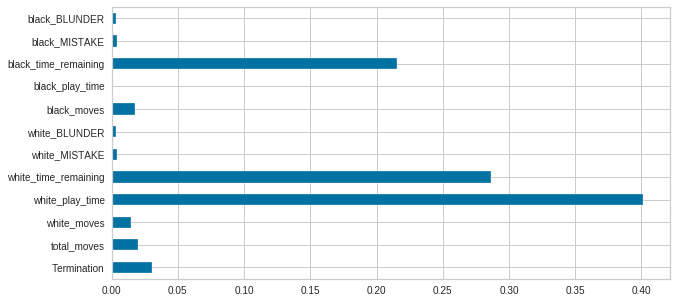

In [ ]:
# Select Best Features based on best prediction for target = WhiteEloClass

# Data
X = df_3
Y = target_df_3

# Build Model
model = ExtraTreesClassifier()
model.fit(X,Y)

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nlargest(15).plot(kind='barh')

fig = plt.figure(figsize=(10,5))
feat_importances.plot(kind='barh')
plt.show()

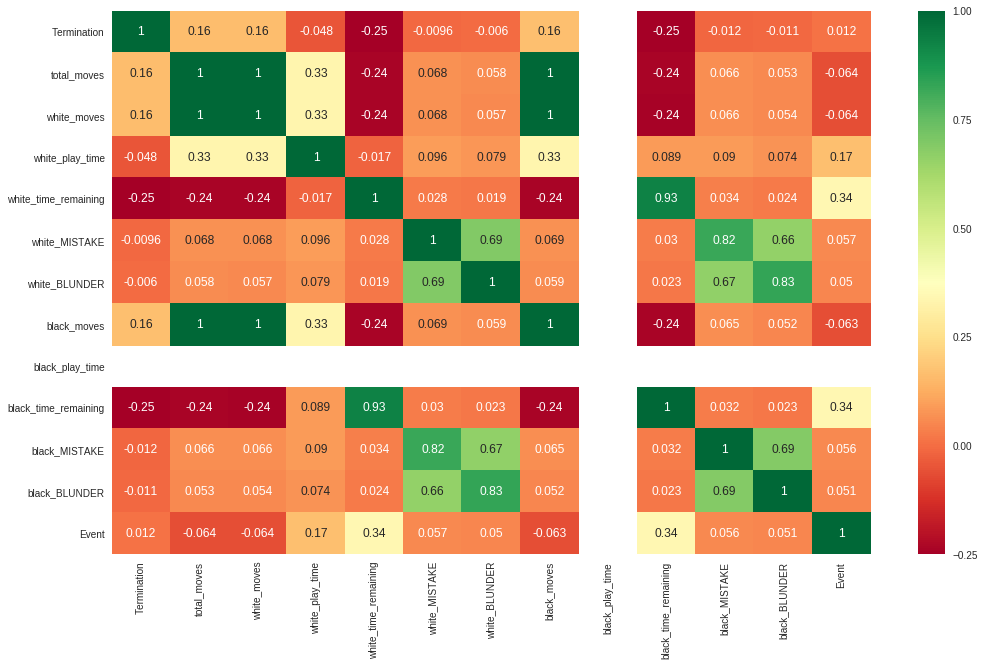

In [ ]:
# Get Correlation

# Select Features
cols = list(feat_importances.index)

# Add SalePrice to Best Features to compare correlation
cols.append('Event')
corr_df_3 = temp_df[cols]

# Find Correlation
corrmat = corr_df_3.corr()
top_corr_features = corrmat.index

# Plot Heat Map
plt.figure(figsize=(17,10))
g=sns.heatmap(temp_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#### **Logistic Regression**

In [ ]:
# Train Model
logreg_3 = LogisticRegression().fit(X_train_3, y_train_3)

# Save Model
pickle.dump(logreg_3, open(loc_model3+'logreg_3.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
# Use Saved Model
logreg_3m = pickle.load(open(loc_model3+'logreg_3.sav', 'rb'))

In [ ]:
# Prediction
prediction_logreg_3 = logreg_3.predict(X_test_3)

# Accuracy
print ("Accuracy: %.2f%%" % (accuracy_score(y_test_3, prediction_logreg_3)*100))

Accuracy: 91.76%


#### **KNN**

In [ ]:
# Train Model
knn_3 = KNeighborsClassifier().fit(X_train_3, y_train_3)

# Save Model
pickle.dump(knn_3, open(loc_model3+'knn_3.sav', 'wb'))

In [ ]:
# Use Saved Model
knn_3m = pickle.load(open(loc_model3+'knn_3.sav', 'rb'))

In [ ]:
# Prediction
prediction_knn_3 = logreg_3.predict(X_test_3)

# Accuracy
print ("Accuracy: %.2f%%" % (accuracy_score(y_test_3, prediction_knn_3)*100))

Accuracy: 91.76%


#### **Decision Tree**

In [ ]:
# Train Model
dt_3 = DecisionTreeClassifier().fit(X_train_3, y_train_3)

# Save Model
pickle.dump(dt_3, open(loc_model3+'dt_3.sav', 'wb'))

In [ ]:
# Use Saved Model
dt_3m = pickle.load(open(loc_model3+'dt_3.sav', 'rb'))

In [ ]:
# Prediction
prediction_dt_3 = dt_3.predict(X_test_3)

# Accuracy
print ("Accuracy: %.2f%%" % (accuracy_score(y_test_3, prediction_dt_3)*100))

Accuracy: 96.15%


#### **SVM**

In [ ]:
# Train Model
# svm_3 = SVC(kernel='linear').fit(X_train_3, y_train_3)

# Save Model
# pickle.dump(svm_3, open(loc_model3+'svm_3.sav', 'wb'))

In [ ]:
# Use Saved Model
# svm_3m = pickle.load(open(loc_model3+'svm_3.sav', 'rb'))

In [ ]:
# Prediction
# prediction_svm_3 = svm_3.predict(X_test_3)

# Accuracy
# print ("Accuracy: %.2f%%" % (accuracy_score(y_test_3, prediction_svm_3)*100))

#### **Random Forest**

In [ ]:
# Train Model
rf_3 = RandomForestClassifier().fit(X_train_3, y_train_3)

# Save Model
pickle.dump(rf_3, open(loc_model3+'rf_3.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
# Use Saved Model
rf_3m = pickle.load(open(loc_model3+'rf_3.sav', 'rb'))

In [ ]:
# Prediction
prediction_rf_3 = rf_3.predict(X_test_3)

# Accuracy
print ("Accuracy: %.2f%%" % (accuracy_score(y_test_3, prediction_rf_3)*100))

Accuracy: 97.37%


#### **XGB**

In [ ]:
# Train Model
xgb_3 = XGBClassifier().fit(X_train_3, y_train_3)

# Save Model
pickle.dump(xgb_3, open(loc_model3+'xgb_3.sav', 'wb'))

In [ ]:
# Use Saved Model
xgb_3m = pickle.load(open(loc_model3+'xgb_3.sav', 'rb'))

In [ ]:
# Prediction
prediction_xgb_3 = xgb_3.predict(X_test_3)

# Accuracy
print ("Accuracy: %.2f%%" % (accuracy_score(y_test_3, prediction_xgb_3)*100))

Accuracy: 97.13%


#### **Light GBM**

In [ ]:
# Find number of classes
count  = temp_df['Event'].value_counts()

parameters = {
    'application': 'multiclass',
    'objective': 'multiclass',
    'num_class': count.size,
    'metric': 'multi_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

categorical_features_3 = [c for c, col in enumerate(df_3.columns) if 'cat' in col]
train_data_3 = lightgbm.Dataset(X_train_3, label=y_train_3, categorical_feature=categorical_features_3)
test_data_3 = lightgbm.Dataset(X_test_3, label=y_test_3)

In [ ]:
# Train Model
lgbm_3 = lightgbm.train(parameters,
                       train_data_3,
                       valid_sets=test_data_3,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

# Save Model
pickle.dump(lgbm_3, open(loc_model3+'lgbm_3.sav', 'wb'))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's multi_logloss: 1.07467
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's multi_logloss: 1.03771
[3]	valid_0's multi_logloss: 0.981794
[4]	valid_0's multi_logloss: 0.939269
[5]	valid_0's multi_logloss: 0.909763
[6]	valid_0's multi_logloss: 0.856329
[7]	valid_0's multi_logloss: 0.830838
[8]	valid_0's multi_logloss: 0.797917
[9]	valid_0's multi_logloss: 0.771075
[10]	valid_0's multi_logloss: 0.739037
[11]	valid_0's multi_logloss: 0.715111
[12]	valid_0's multi_logloss: 0.696899
[13]	valid_0's multi_logloss: 0.66726
[14]	valid_0's multi_logloss: 0.651957
[15]	valid_0's multi_logloss: 0.62034
[16]	valid_0's multi_logloss: 0.602148
[17]	valid_0's multi_logloss: 0.576794
[18]	valid_0's multi_logloss: 0.553136
[19]	valid_0's multi_logloss: 0.545438
[20]	valid_0's multi_logloss: 0.530918
[21]	valid_0's multi_logloss: 0.517395
[22]	valid_0's multi_logloss: 0.500244
[23]	valid_0's multi_logloss: 0.486844
[24]	valid_0's multi_logloss: 0.473334
[25]	valid_0's

In [ ]:
# Use Saved Model
lgbm_3m = pickle.load(open(loc_model3+'lgbm_3.sav', 'rb'))

In [ ]:
# Prediction
prediction_lgbm_3 = lgbm_3.predict(X_test_3)

### **4. Predict Result from Board Position**

In [ ]:
# Update Models location
loc_model4 = loc+'PredictResultClass/'

#### **Data Processing**

In [ ]:
# Convert PGN to CSV

# import re
# import glob
# from tqdm import tqdm

# def process():
#     COLS_HEADERS = "a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,c2,d2,e2,f2,g2,h2,a3,b3,c3,d3,e3,f3,g3,h3,a4,b4,c4,d4,e4,f4,g4,h4,a5,b5,c5,d5,e5,f5,g5,h5,a6,b6,c6,d6,e6,f6,g6,h6,a7,b7,c7,d7,e7,f7,g7,h7,a8,b8,c8,d8,e8,f8,g8,h8,whos_move,fen,result"
    
#     # returns row vector corresponding to row fen string
#     def vectorize_stripped_fen(fen_row_string):
#         row_vector = []
#         row_elements = list(fen_row_string)
#         for elem in row_elements:
#             if elem.isdigit():
#                 for num in range(int(elem)):
#                     row_vector.append(0) # if the elem is a number, set that number of preceeding elements to empty squares (0)
#             else:
#                 row_vector.append(elem) # if the elem is a piece (letter)
#         return row_vector

#     def get_num_lines(filename):
#         return sum(1 for line in open(filename))

#     regex = r'(\{(.*?)\}\ ((1\-0)|(0\-1)|(1\/2\-1\/2)))'
#     outputfile = open("ResultPrediction_ProcessedCSV.csv",'w')
#     outputfile.write(COLS_HEADERS + "\r\n")

#     for filename in glob.glob("ResultPredictionProcessed.pgn"):
        
#         # print("Reading " + filename + " ... ")
#         with open(filename, "r") as f:
#             for line in tqdm(f, ascii=True, desc=filename, total=get_num_lines(filename)):
#                 match = re.search(regex, line)
#                 if match is not None:
#                     fen, result = match.group(0)[2:].split('}')[:2]
#                     position, whosmove = fen.split(' ')[:2]
#                     position = position[1:].replace('"', '')
#                     rows = position.split('/')
#                     row_vectors = []
#                     position_vector = []
#                     for row in rows:
#                         row_vectors = vectorize_stripped_fen(row) + row_vectors
#                     position_vector = row_vectors
#                     outputfile.write(",".join(str(x) for x in position_vector) + "," + whosmove + "," + fen.replace('"', '') + "," + result.strip() + "\r\n")

# process()

In [ ]:
# Read Processed Output
processed_output_df = pd.read_csv('ResultPrediction_ProcessedCSV.csv')
processed_output_df

,a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,c2,d2,e2,f2,g2,h2,a3,b3,c3,d3,e3,f3,g3,h3,a4,b4,c4,d4,e4,f4,g4,h4,a5,b5,c5,d5,e5,f5,g5,h5,a6,b6,c6,d6,e6,f6,g6,h6,a7,b7,c7,d7,e7,f7,g7,h7,a8,b8,c8,d8,e8,f8,g8,h8,whos_move,fen,result
0,R,0,0,0,K,0,0,R,0,P,P,0,0,P,P,P,P,0,N,0,0,0,0,0,0,0,0,P,P,0,0,q,0,0,0,0,0,0,0,B,0,p,n,0,p,0,0,0,p,b,p,p,0,0,0,p,r,0,0,k,Q,b,0,r,b,r2kQb1r/pbpp3p/1pn1p3/7B/3PP2q/P1N5/1PP2PPP/R3...,1-0
1,R,0,0,0,0,0,0,0,P,P,P,K,0,P,P,0,0,0,0,B,0,0,0,0,0,0,0,n,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,b,p,0,p,0,p,p,p,k,0,p,0,0,0,0,0,0,0,0,0,B,b,7B/pppk1p2/3bp1p1/8/3nN3/3B4/PPPK1PP1/R7 b - -...,1-0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,K,0,p,k,0,0,0,0,0,0,0,0,0,0,b,P,0,0,0,0,0,0,P,0,p,0,0,0,0,0,p,0,0,0,0,0,0,0,0,0,w,8/p5p1/6P1/6bP/K1pk4/8/8/8 w - - 0 48,0-1
3,R,0,B,0,0,K,0,0,P,P,0,N,0,0,0,0,0,0,P,P,0,0,0,b,0,0,0,0,0,P,0,0,0,0,p,p,P,0,0,p,0,q,0,0,0,0,0,0,p,p,0,0,0,k,p,0,r,0,0,0,0,b,0,r,w,r4b1r/pp3kp1/1q6/2ppP2p/5P2/2PP3b/PP1N4/R1B2K2...,0-1
4,0,0,0,0,0,R,K,0,P,0,0,0,0,P,0,P,0,0,0,0,0,0,P,0,0,0,0,0,0,0,0,0,0,0,0,Q,0,0,p,0,0,0,0,0,0,0,0,p,0,0,p,k,0,p,0,0,0,0,0,0,0,0,0,0,b,8/2pk1p2/7p/3Q2p1/8/6P1/P4P1P/5RK1 b - - 0 32,1-0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110943,0,K,0,0,0,0,0,R,P,0,0,0,0,0,B,P,b,P,0,0,0,0,0,0,0,0,0,r,0,0,p,0,0,0,0,0,r,b,0,0,p,k,p,0,0,0,0,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,w,8/8/pkp4R/4rb2/3r2p1/bP6/P5BP/1K5R w - - 11 39,0-1
110944,R,K,B,0,0,0,0,r,0,P,0,0,0,P,P,P,P,0,0,0,0,0,0,0,0,0,0,0,P,0,0,0,0,0,b,0,0,0,0,0,0,0,0,0,0,n,0,0,p,p,0,0,0,b,p,p,0,0,k,r,0,0,0,0,w,2kr4/pp3bpp/5n2/2b5/4P3/P7/1P3PPP/RKB4r w - - ...,0-1
110945,0,0,0,0,q,K,0,0,0,0,0,k,0,0,0,0,0,0,0,0,0,p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,p,P,0,0,0,0,0,0,0,p,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,w,8/p7/P7/7p/8/5p2/3k4/4qK2 w - - 2 52,0-1
110946,0,0,K,R,0,0,0,0,P,P,P,0,0,P,0,0,0,0,0,0,B,0,0,P,0,0,0,0,0,q,0,0,0,0,0,0,0,0,p,0,0,0,Q,p,0,0,0,0,0,0,p,0,R,0,b,p,0,0,k,r,0,0,0,0,b,2kr4/2p1R1bp/2Qp4/6p1/5q2/4B2P/PPP2P2/2KR4 b -...,1-0


In [ ]:
processed_output_df.shape

(110948, 67)

In [ ]:
# Label Encoding
new_df = processed_output_df.copy()

# Categorical boolean mask
cat_ft1 = new_df.dtypes==object

# filter categorical columns using mask and turn it into a list
cat_cols1 = new_df.columns[cat_ft1].tolist()

# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
new_df[cat_cols1] = new_df[cat_cols1].apply(lambda col: le.fit_transform(col.astype(str)))

In [ ]:
# Split Data into train and test
X = new_df.copy()
Y = new_df['result'].copy()
X.drop(['result'], axis=1, inplace=True)

# Split Data
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, Y, test_size=0.2)

#### **DNN Classifier**

In [ ]:
import tensorflow as tf
import numpy as np
import logging as log

def input_fn():
    return feature_cols, labels

# Specify that all features have real-value data
feature_columns = [tf.feature_column.numeric_column("x", shape=[len(X_train_4.columns),1])]

 # Build 3 layer DNN with 10, 20, 10 units respectively
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                          hidden_units=[50, 50, 50],
                                          n_classes=3,
                                          model_dir=loc_model4)

# Define the training inputs
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": np.array(X_train_4)},
      y=np.array(y_train_4),
      num_epochs=None,
      shuffle=True,
      batch_size=8000)

# Train model
classifier.train(input_fn=train_input_fn, steps=40000)

# Define the test inputs
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": np.array(X_test_4)},
      y=np.array(y_test_4),
      num_epochs=1,
      shuffle=False)

# Prediction
pred = classifier.predict(input_fn = test_input_fn)
predictions = list(pred)

# Evaluate accuracy
accuracy_score = classifier.evaluate(input_fn = test_input_fn)["accuracy"]
print("\nTest Accuracy: {0:f}\n".format(accuracy_score))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/content/drive/Shared drives/DSF_Project/Models/100000_AllFeat_LE/PredictResultClass/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7683675780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_r

#### **UI**

In [ ]:
cd '/content/drive/Shared drives/DSF_Project/Code/Chess_UI'

/content/drive/Shared drives/DSF_Project/Code/Chess_UI


In [ ]:
chess_ui.py

In [ ]:
from flask import Flask, flash, request, redirect, render_template
from wtforms import Form, TextField, TextAreaField, validators, StringField, SubmitField
import pandas as pd
import tablib
import os
import pickle
import lichess.api
from lichess.format import PYCHESS
import chess.pgn


# App config.
# DEBUG = True

model_eloReg_white=pickle.load(open('models/lgbm_w2.sav', 'rb'))
model_eloReg_black=pickle.load(open('models/lgbm_b2.sav', 'rb'))

app = Flask(__name__)
app.config.from_object(__name__)
app.config['SECRET_KEY'] = '7d441f27d441f27567d441f2b6176a'
	
@app.route('/')
def main():
    return render_template('main.html')


@app.route('/', methods=['POST'])
def upload_file():
    link_text=request.form['link_text']
    pred_type=request.form['submit_button']
    if pred_type=='Predict Elo Rating':
        print('yo')        
    if pred_type=='Classify Elo Rating':
        print('yo Classify') 
    if pred_type=='Predict Game Type':
        print('yo game type')

        
    
    game = lichess.api.game(link_text, format=PYCHESS)

    # final_board=game.end().board()
    
    return render_template('result.html',pred_type=pred_type)

app.run()